In [3]:
# IMPORTS

from arch import arch_model
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# import facebook prophet
from prophet import Prophet


c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\AlisyaMustikaa\AppData\Local\Temp\ipykernel_26956\2818894217.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  afrr_df = pd.read_csv("../raw_data/afrr mwh.csv")


         Year        KA        ND        IA
0  2019-01-01     0.000     0.000     0.000
1  2020-01-01     0.000     0.000     0.000
2  2021-01-01     0.000     0.000     0.000
3  2022-01-01    39.250    39.250    39.250
4  2023-01-01    85.750    85.750    85.750
5  2024-01-01   267.875   467.875   205.375
6  2025-01-01   450.000   850.000   325.000
7  2026-01-01   735.000  1315.000   520.000
8  2027-01-01  1020.000  1780.000   715.000
9  2028-01-01  1305.000  2245.000   910.000
10 2029-01-01  1590.000  2710.000  1105.000
11 2030-01-01  1875.000  3175.000  1300.000
12 2031-01-01  2180.000  3515.000  1440.000
13 2032-01-01  2485.000  3855.000  1580.000
14 2033-01-01  2790.000  4195.000  1720.000
15 2034-01-01  3095.000  4535.000  1860.000
16 2035-01-01  3400.000  4875.000  2000.000


Text(0.5, 1.0, 'AFRR Power')

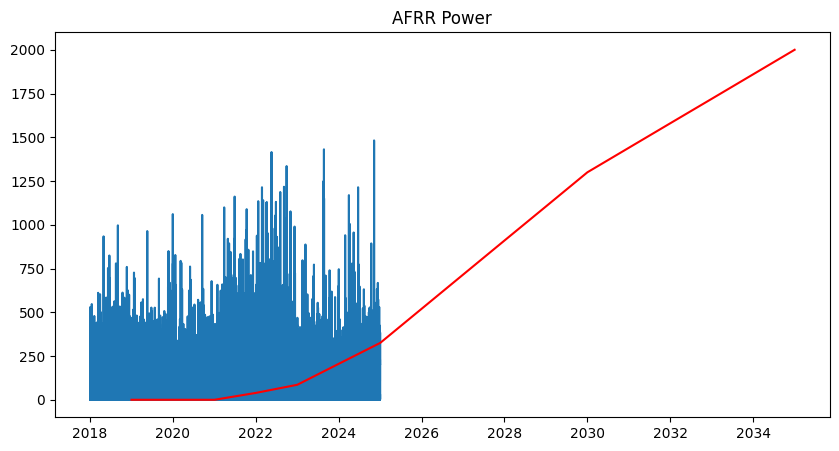

In [9]:
#Load Data
afrr_df = pd.read_csv("../raw_data/afrr mwh.csv")

#convert date column to datetime
afrr_df['date'] = pd.to_datetime(afrr_df['date'], format='%d-%m-%Y %M:%S')

#convert to mwh
afrr_df['power'] = (afrr_df['power']) / 1000

afrr_df


#BESS Capacity (NL) 
data = {
    'Year': [
        2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
        2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035
    ],
    'KA': [
        0, 0, 0, 157, 343, 1071.5, 1800, 2940,
        4080, 5220, 6360, 7500, 8720, 9940, 11160, 12380, 13600
    ],
    'ND': [
        0, 0, 0, 157, 343, 1871.5, 3400, 5260,
        7120, 8980, 10840, 12700, 14060, 15420, 16780, 18140, 19500
    ],
    'IA': [
        0, 0, 0, 157, 343, 821.5, 1300, 2080,
        2860, 3640, 4420, 5200, 5760, 6320, 6880, 7440, 8000
    ]
}

BESScapacity = pd.DataFrame(data)
BESScapacity['Year'] = pd.to_datetime(BESScapacity['Year'], format='%Y')
#divide columns by 4
BESScapacity['KA'] = (BESScapacity['KA']/4) 
BESScapacity['ND'] = (BESScapacity['ND']/4) 
BESScapacity['IA'] = (BESScapacity['IA']/4) 

print(BESScapacity)


#plot the data
plt.figure(figsize=(10, 5))
plt.plot(afrr_df['date'], afrr_df['power'])
plt.plot(BESScapacity['Year'], BESScapacity['IA'], label='IA', color='red')
plt.title('AFRR Power')


10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:55 - cmdstanpy - INFO - Chain [1] done processing


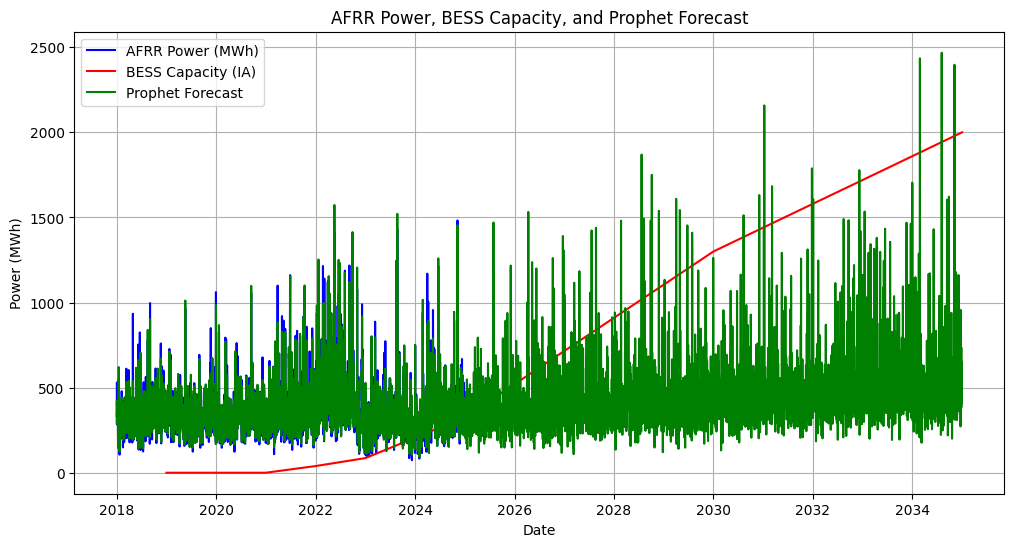

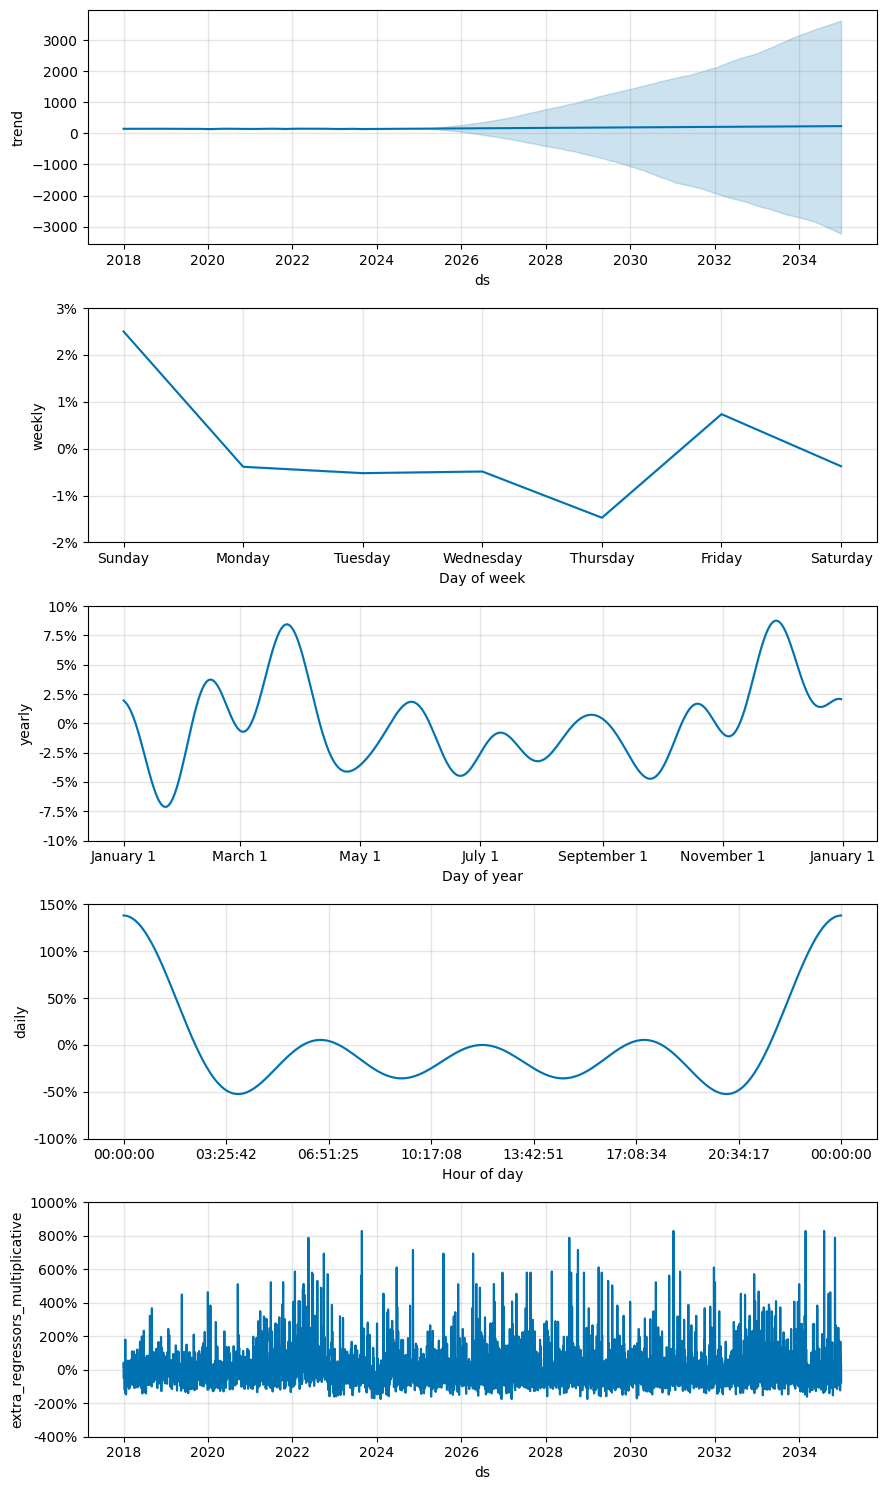

In [25]:
#set seed for reproducibility
np.random.seed(42)

# Step 1: Prepare data
afrr_df = afrr_df.copy()
# afrr_df = afrr_df[afrr_df['power'] != 0]

# Use rolling standard deviation (e.g., 7-day window)
afrr_df['std'] = afrr_df['power'].rolling(window=7, min_periods=1).std()

# Resample to daily max power and corresponding std
daily_df = afrr_df.resample('D', on='date').agg({'power': 'max', 'std': 'max'}).reset_index()
daily_df.columns = ['ds', 'y', 'std']

# Drop rows with NaN
daily_df.dropna(inplace=True)

# Step 2: Setup Prophet model with external regressor
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    interval_width=0.95,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5
)
model.add_regressor('std')

# Step 3: Fit model
model.fit(daily_df)

# Step 4: Forecast future
future = model.make_future_dataframe(periods=365*10, freq='D')

# Merge past std values for existing dates
future = future.merge(daily_df[['ds', 'std']], on='ds', how='left')

# Fill missing future std with random samples from historical stds
observed_stds = daily_df['std'].dropna().values
future['std'] = future['std'].fillna(
    pd.Series(np.random.choice(observed_stds, size=len(future)))
)

# Step 5: Make predictions
forecast_afrr = model.predict(future)

# Step 6: Plot results
plt.figure(figsize=(12, 6))
plt.plot(daily_df['ds'], daily_df['y'], label='AFRR Power (MWh)', color='blue')
plt.plot(BESScapacity['Year'], BESScapacity['IA'], label='BESS Capacity (IA)', color='red')
plt.plot(forecast_afrr['ds'], forecast_afrr['yhat'], label='Prophet Forecast', color='green')
plt.title('AFRR Power, BESS Capacity, and Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Power (MWh)')
plt.legend()
plt.grid()
plt.show()

# Step 7: Prophet components
model.plot_components(forecast_afrr)
plt.show()


In [1]:
def forecast_with_scenarios(model, outcome="Imbalance", feature_names=["RESP", "NG_Price", "BESS", "EUA"],
                            future_data_path="processed_data/Future dataset with BESS.csv",
                            historical_data_path="processed_data/historical_data.csv",
                            show_plot=True):
    """
    Forecasts future scenarios using the trained model and specified features, including monthly dummies.
    """
    future_data = pd.read_csv(future_data_path, parse_dates=["Date"])
    future_data["month"] = future_data["Date"].dt.month

    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)

    # Prepare month dummies (must match training: months 2–12, drop January)
    month_dummies = pd.get_dummies(future_data["month"], prefix="Month", drop_first=True)

    # Mapping future scenario columns to standardized features
    scenario_mapping = {
        "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
        "NG_Price": ["Ga", "Gb", "Gc"],
        "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"],
    }

    scenario_combinations = list(itertools.product(
        *[scenario_mapping[key] for key in scenario_mapping.keys()]
    ))

    future_combination_dfs = []
    for combination in scenario_combinations:
        combination_name = "_".join(combination)

        try:
            # Base features
            temp_df = pd.DataFrame({
                "RESP": future_data[combination[0]].values,
                "NG_Price": future_data[combination[1]].values,
                "BESS": future_data[combination[2]].values,
            })

            # Combine with month dummies
            X_future = pd.concat([temp_df, month_dummies], axis=1)

            # Add constant and ensure float type
            X_future = sm.add_constant(X_future).astype(float)

            # Predict revenue
            revenue_forecast = model.predict(X_future)

            # Store forecast
            future_comb_df = pd.DataFrame({
                "Date": future_data["Date"],
                f"Total Revenue Forecast ({combination_name})": revenue_forecast
            })
            future_combination_dfs.append(future_comb_df.set_index("Date"))

        except KeyError as e:
            print(f"Missing column in combination {combination}: {e}")
            continue

    all_forecasts = pd.concat(future_combination_dfs, axis=1)

    if show_plot:
        plt.figure(figsize=(20, 5))
        plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
        for column in all_forecasts.columns:
            plt.plot(all_forecasts.index, all_forecasts[column], label=column)
        plt.title(f"Forecasts for {outcome} Revenue Across Scenarios")
        plt.grid(True)
        plt.show()

    return all_forecasts


def forecast_with_scenarios_rolling(model, outcome="Imbalance", feature_names=["RESP", "NG Price", "BESS"],
                                     future_data_path="processed_data/Future dataset with BESS.csv",
                                     historical_data_path="processed_data/historical_data.csv",
                                     include_lag=False, show_plot=True):
    
    if not include_lag:
        all_forecasts = forecast_with_scenarios(model, outcome, feature_names, future_data_path, historical_data_path, show_plot)
    else:
        future_data = pd.read_csv(future_data_path, parse_dates=["Date"])
        future_data["month"] = future_data["Date"].dt.month

        historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
        historical_data.set_index("Date", inplace=True)

        # Mapping future scenario columns to standardized features
        scenario_mapping = {
            "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
            "NG Price": ["Ga", "Gb", "Gc"],
            "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"]
        }

        # Generate all combinations of scenarios
        scenario_combinations = list(itertools.product(
            *[scenario_mapping[key] for key in scenario_mapping.keys()]
        ))

        # Create DataFrame for each scenario combination
        future_combination_dfs = []
        for combination in scenario_combinations:
            combination_name = "_".join(combination)

            try:
                forecast_values = []
                last_lag = historical_data["Day-ahead Only"].iloc[-1] if include_lag else None

                for t in range(len(future_data)):
                    row = {
                        "RESP": future_data.loc[t, combination[0]],
                        "NG Price": future_data.loc[t, combination[1]],
                        "BESS": future_data.loc[t, combination[2]]
                    }

                    row["Day Ahead Lag"] = last_lag

                    X_input = pd.DataFrame([row])
                    X_input["const"] = 1
                    X_input = X_input[["const"] + [col for col in X_input.columns if col != "const"]]

                    prediction = model.predict(X_input)[0]
                    forecast_values.append(prediction)

                    last_lag = prediction

                forecast_df = pd.DataFrame({
                    "Date": future_data["Date"],
                    f"Total Revenue Forecast ({combination_name})": forecast_values
                })
                future_combination_dfs.append(forecast_df.set_index("Date"))

            except KeyError as e:
                print(f"Missing column in combination {combination}: {e}")
                continue

        # Combine all scenario forecasts
        all_forecasts = pd.concat(future_combination_dfs, axis=1)

        # Plot results
        if show_plot:
            plt.figure(figsize=(20, 5))
            plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
            for column in all_forecasts.columns:
                plt.plot(all_forecasts.index, all_forecasts[column], label=column)
            plt.title("Rolling Forecast with Scenarios")
            plt.xlabel("Date")
            plt.ylabel("Forecasted Revenue")
            plt.grid(True)
            plt.show()

    return all_forecasts


In [6]:
# Load main data
df = pd.read_csv("../processed_data/monthly_imbalance_only.csv", parse_dates=["Date"])[["imbalance_total", "Date"]]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.iloc[1:]  # Delete first month
df = df.reset_index()

# Load external regressors
regressors = pd.read_csv("../processed_data/historical_data.csv", parse_dates=["Date"])
regressors['Date'] = pd.to_datetime(regressors['Date'])
#drop NG_price from regressors
regressors = regressors.drop(columns=["NG_Price"], axis=1)

# Merge regressors with main df
df_merged = pd.merge(df, regressors, left_on='Date', right_on='Date', how='left')
print(df_merged)

         Date  imbalance_total        BESS    EUA         RESP     Imbalance  \
0  2021-02-28         9678.224   49.090909  68.40  2345.436662  11967.316841   
1  2021-03-31        12221.497   53.181818  64.58  2631.347361  15309.577246   
2  2021-04-30         9082.683   57.272727  65.56  2937.190234  10925.326974   
3  2021-05-31        13223.984   61.363636  70.30  2933.630880  14854.763637   
4  2021-06-30        13695.495   65.454545  69.24  2578.836123  17594.166874   
5  2021-07-31        11039.300   69.545455  67.36  2737.535303  14358.314995   
6  2021-08-31        18274.748   73.636364  74.07  2921.437443  24165.506323   
7  2021-09-30        13135.380   77.727273  69.20  2149.879985  19289.042689   
8  2021-10-31        19489.828   81.818182  61.93  2842.973577  33695.241070   
9  2021-11-30        20490.574   85.909091  56.44  1884.246252  25491.509283   
10 2021-12-31        18268.132   90.000000  64.40  2217.839669  28396.744520   
11 2022-01-31        21174.880   95.5833